# Dev

- [] Fix the categorical knowledge graph

In [1]:
%load_ext autoreload
%autoreload all
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [1]:
import os
import sys
import pickle
import networkx as nx
import matplotlib as mpl
import numpy as np
import random
import matplotlib.pyplot as plt
import re
from pprint import pprint

# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# from StructuredRag.evaluation import graph_scoring
# from StructuredRag.processing import graph_construction
# from StructuredRag.algorithms import v0, v1
from StructuredRag.processing import distance_metrics
from StructuredRag.etl import embedding_funcs, etl_funcs

/Users/lukasalemu/Downloads/ls/envs/dissertation_rag/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Reload our data

In [2]:
# Select the runs you want to load
for experiment in sorted(os.listdir('../results')):
    print('Experiment:', experiment)
    for run in sorted(os.listdir('../results/' + experiment)):
        print("     || Run:", run)

Experiment: v0
     || Run: 2024-05-10
     || Run: 2024-05-14
     || Run: 2024-05-25
     || Run: 2024-05-27
     || Run: 2024-06-14
     || Run: 2024-07-18
     || Run: 2024-08-03
Experiment: v1
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v3
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v4
     || Run: 2024-05-10
     || Run: 2024-05-14
Experiment: v5
     || Run: 2024-05-14


In [3]:
run_path = 'v0/2024-08-03'

data = {}
# Read the data for the specified experiment
for item in os.listdir('../results/' + run_path):
    print('Loading item:', item.split('.')[0])
    
    with open('../results/' + run_path + '/' + item, 'rb') as f:
        data[item.split('.')[0]] = pickle.load(f)

Loading item: embedded_index
Loading item: notes
Loading item: edge_thresh
Loading item: adj_matrix


### Date calculation

In [67]:
import pandas as pd
def scaled_date_difference(doc0, doc1):
    """
    Scales the difference between two dates and returns a value between -1 and 1.
    The function I've created is a bit odd.

    Parameters:
    date0 (str or datetime): The base date.
    date1 (str or datetime): The date to compare with the base date.

    Returns:
    float: The scaled difference between the two dates. Higher is better. Max 1.

    """
    # Try to convert the dates to datetime objects
    date0 = pd.to_datetime(doc0)
    date1 = pd.to_datetime(doc1)

    diff = (date0 - date1).days

    # Intuition - if date 1 > date 0 by a lot then it likely isn't related at all
    if diff < -90:
        return -1

    # Intuition - if date 1 < date 0 by a lot then it likely isn't related at all
    elif diff > 365:
        return -1

    # Intuition - if the difference is within a week, return 1
    elif -15 < diff < 15:
        return 1

    # Scale the diff to be between -1 and 1, with the min and max values being -365 and +365
    else:
        scaled_diff = 2 * (diff + 365) / 720 - 1
        # Return the scaled diff as the output of a smoothing 1/x function
        return round(1 / (0.5 + scaled_diff**2) - 1, 3)

In [84]:

def scaled_date_difference2(doc0, doc1):
    """
    Scales the difference between two dates and returns a value between -1 and 1.
    The function I've created is a bit odd.

    Parameters:
    date0 (str or datetime): The base date.
    date1 (str or datetime): The date to compare with the base date.

    Returns:
    float: The scaled difference between the two dates. Higher is better. Max 1.

    """
    # Try to convert the dates to datetime objects
    date0 = pd.to_datetime(doc0)
    date1 = pd.to_datetime(doc1)

    diff = (date0 - date1).days

    # Intuition - if date 1 > date 0 by a lot then it likely isn't related at all
    if diff < -90:
        return -1

    # Intuition - if date 1 < date 0 by a lot then it likely isn't related at all
    elif diff > 365:
        return -1

    # Intuition - if the difference is within a week, return 1
    elif -15 < diff < 15:
        return 1

    # Scale the diff to be between -1 and 1, with the min and max values being -365 and +365
    else:
        scaled_diff = diff/365
        # Return the scaled diff as the output of a smoothing 1/x function
        return round(1 / (0.5 + scaled_diff**2) - 1, 3)

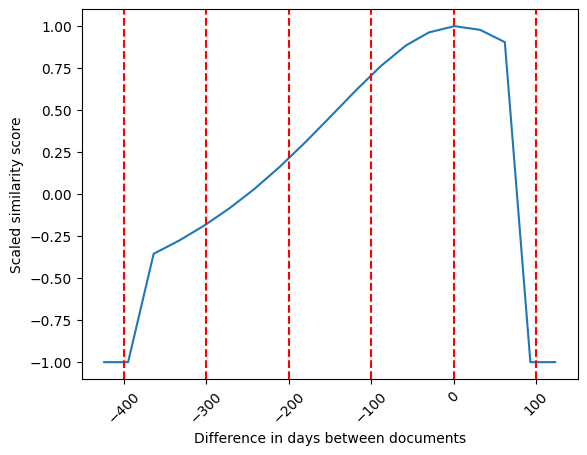

In [76]:
date_range1 = pd.date_range(start='8/01/2018', end='3/1/2020', freq='ME')

score_holder = []
for d1 in date_range1:
    score_holder.append(scaled_date_difference(d1, '1/1/2019'))

days_difference = [(pd.Timestamp('1/1/2019') - d).days for d in date_range1]

plt.plot(days_difference, score_holder)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))

# plt.axvline(x=-500, color='red', linestyle='--')
plt.axvline(x=-400, color='red', linestyle='--')
plt.axvline(x=-300, color='red', linestyle='--')
plt.axvline(x=-200, color='red', linestyle='--')
plt.axvline(x=-100, color='red', linestyle='--')
plt.axvline(x=000, color='red', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')
# plt.axvline(x=200, color='red', linestyle='--')
# plt.axvline(x=300, color='red', linestyle='--')
plt.xlabel('Difference in days between documents')
plt.ylabel('Scaled similarity score')
plt.show()


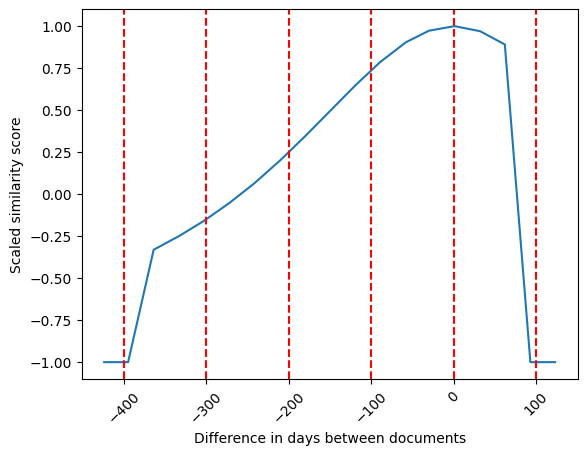

In [85]:
date_range1 = pd.date_range(start='8/01/2018', end='3/1/2020', freq='ME')

score_holder = []
for d1 in date_range1:
    score_holder.append(scaled_date_difference2(d1, '1/1/2019'))

days_difference = [(pd.Timestamp('1/1/2019') - d).days for d in date_range1]

plt.plot(days_difference, score_holder)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))

# plt.axvline(x=-500, color='red', linestyle='--')
plt.axvline(x=-400, color='red', linestyle='--')
plt.axvline(x=-300, color='red', linestyle='--')
plt.axvline(x=-200, color='red', linestyle='--')
plt.axvline(x=-100, color='red', linestyle='--')
plt.axvline(x=000, color='red', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')
# plt.axvline(x=200, color='red', linestyle='--')
# plt.axvline(x=300, color='red', linestyle='--')
plt.xlabel('Difference in days between documents')
plt.ylabel('Scaled similarity score')
plt.show()


In [41]:
# ### Load the embedded index
# run_path = 'v0/2024-05-17'

# data = {}
# # Read the data for the specified experiment
# for item in os.listdir('../results/' + run_path):
#     print('Loading item:', item.split('.')[0])
    
#     with open('../results/' + run_path + '/' + item, 'rb') as f:
#         data[item.split('.')[0]] = pickle.load(f)

# embedded_index = data['embedded_index']

Loading item: adj_matrix
Loading item: embedded_index
Loading item: notes


# Improve the Doctype calculation

In [11]:
### Print out all the different types of document
doc_types = []
for doc in document_index:
    doc_types.append(doc.metadata['Type'])

set(doc_types)

{'Background Reading',
 'Data Response',
 'Essential Reading',
 'Monetary Policy Report',
 'Recommended reading',
 'Speech'}

### Def the old function

In [61]:
def lcl_doctype_distance_metric(doc0, doc1):
    """
    Calculates the distance metric between two document types based on a knowledge graph.

    Parameters:
    - doc0 (Document): The first document.
    - doc1 (Document): The second document.

    Returns:
    - float: The distance metric between the document types. The value is scaled between -1 and 1.

    Raises:
    - ValueError: If the document types are not found in the knowledge graph.
    - ValueError: If no path is found between the document types in the knowledge graph.
    """

    doc_type1 = doc0.metadata["Type"].lower()
    doc_type2 = doc1.metadata["Type"].lower()

    # doc_knowledge_graph = {
    #     "Background Reading": {"Data Response": 0.5, "Essential Reading": 0.3, "Monetary Policy Report": 0.0, "Recommended reading": 0.8, "Speech": 0.7},
    #     "Data Response": {"Essential Reading": 0.4, "Monetary Policy Report": 0.4, "Recommended reading": 0.8, "Speech": 0.0},
    #     "Essential Reading": {"Monetary Policy Report": 0.7, "Recommended reading": 0.4, "Speech": 0.0},
    #     "Monetary Policy Report": {"Recommended reading": 0.4, "Speech": 0.6},
    #     "Recommended reading": {"Speech": 0.0},
    # }

    doc_knowledge_graph = {
        "background reading": {"data response": 0.5, "essential reading": 0.3, "monetary policy report": 0.0, "recommended reading": 0.8, "speech": 0.7},
        "data response": {"essential reading": 0.4, "monetary policy report": 0.4, "recommended reading": 0.8, "speech": 0.0},
        "essential reading": {"monetary policy report": 0.7, "recommended reading": 0.4, "speech": 0.0},
        "monetary policy report": {"recommended reading": 0.4, "speech": 0.6},
        "recommended reading": {"speech": 0.0},
    }
    
    # If the document types are the same, return 1
    if doc_type1 == doc_type2:
        return 1

    try: 
        distance = doc_knowledge_graph[doc_type1].get(
            doc_type2
        )
    except:
        # Reverse the order
        distance = doc_knowledge_graph[doc_type2].get(
            doc_type1
        )
    
    if distance is None:
        return 0
        # raise ValueError(
        #     f"No path found between the document types in the knowledge graph: {doc_type1} and {doc_type2}"
        # )

    # Scale the distance to be between -1 and 1
    scaled_distance = round(2 * (distance - 0.5), 3)

    return scaled_distance

In [58]:
doc_knowledge_graph = {
        "Background Reading": {"Data Response": 0.5, "Essential Reading": 0.3, "Monetary Policy Report": 0.0, "Recommended reading": 0.8, "Speech": 0.7},
        "Data Response": {"Essential Reading": 0.4, "Monetary Policy Report": 0.4, "Recommended reading": 0.8, "Speech": 0.0},
        "Essential Reading": {"Monetary Policy Report": 0.7, "Recommended reading": 0.4, "Speech": 0.0},
        "Monetary Policy Report": {"Recommended reading": 0.4, "Speech": 0.6},
        "Recommended reading": {"Speech": 0.0},
    }

doc_type1 = "Background Reading"
doc_type2 = "Recommended reading"

try: 
    distance = doc_knowledge_graph[doc_type1].get(
        doc_type2
    )
except:
    # Reverse the order
    distance = doc_knowledge_graph[doc_type2].get(
        doc_type1
    )

distance

0.8

In [49]:
doc1 = document_index[random.randint(0, 1000)]
doc2 = document_index[random.randint(0, 1000)]

print(doc1.metadata['Type'], '||', doc2.metadata['Type'], '||', lcl_doctype_distance_metric(doc1, doc2))

Essential Reading || Recommended reading || -0.2


<function matplotlib.pyplot.show(close=None, block=None)>

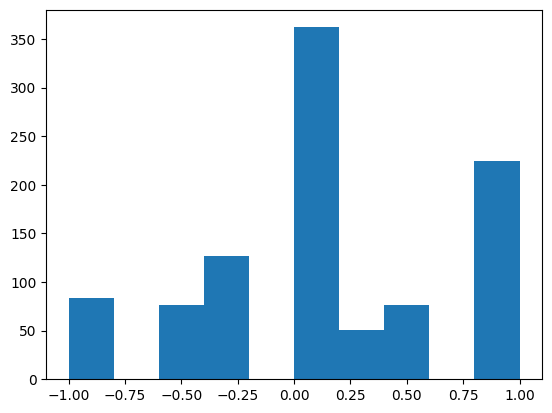

In [62]:
results = []
for i in range(1000):
    doc1 = document_index[random.randint(0, len(document_index)-1)]
    doc2 = document_index[random.randint(0, len(document_index)-1)]

    results.append(
        lcl_doctype_distance_metric(doc1, doc2)
    )

plt.hist(results)
plt.show


Dont think theres much to improve here. Only a couple different types of document

# Authors

In [68]:
def lcl_author_distance_metric(doc0, doc1, fuzz_thresh=80) -> float:
    """
    Calculates the author distance metric between two documents.

    Parameters:
    - doc0 (Document): The first document.
    - doc1 (Document): The second document.
    - fuzz_thresh (int): The threshold for fuzzy matching similarity. Default is 80.

    Returns:
    - float: The scaled similarity between the authors of the two documents.

    """
    authors0 = doc0.metadata["Authors"]
    authors1 = doc1.metadata["Authors"]

    if isinstance(authors0, str):
        authors0 = [name.strip() for name in authors0.split(",")]

    if isinstance(authors1, str):
        authors1 = [name.strip() for name in authors1.split(",")]

    # Calculate the Jaccard similarity between the two author lists
    jacc_sim = distance_metrics.fuzzy_jaccard_similarity(
        set(authors0), set(authors1), threshold=fuzz_thresh
    )

    # Scale the Jaccard similarity to be between -1 and 1
    scaled_similarity = round(2 * jacc_sim - 1, 3)

    return scaled_similarity

In [63]:
doc_types = []
for doc in document_index:
    doc_types.append(doc.metadata['Authors'])

set(doc_types)

{'Alexis Tessier, Luc Tucker',
 'Alice Pugh',
 'Alice Pugh, Lauren Barnes, Edwin Millar',
 'Alice Pugh, Oliver Davies, Jenny Chan, Lauren Barnes, Edwin Millar',
 'Anca Stoian',
 'Angel Chu',
 'Angus Foulis, Saleem Bahaj, Gabor Pinter',
 'Anisha Tibrewal',
 'Annalisa Stoddart',
 'Ariane Curtis',
 'Ashton Middleton',
 'Azuolos Alisauskas, Helena Patterson, Sean Maloney',
 'Colm Manning',
 'David Copple, Jon Paxton',
 'David Latto, Christopher Jackson, Alex Rattan, Edward Hall',
 'David Latto, Liam Crowley-Reidy, Fergal Shortall, Maria Barriel',
 'Fabrizio Cadamagnani',
 'Fabrizio Cadamagnani, Georgina Green, Ryan Murphy',
 'Florence Hubert, Frances Hill, Louise Parreira, Alexis Tessier, Iain Duff',
 'Gabija Zemaityte, Jack Page, Sonal Patel, Mirko Licchetta, Julian Reynolds, James Own',
 'Harry Rigg',
 'Harvey Daniell',
 'Harvey Daniell, Zaar Khan',
 'Helena Patterson, Azuolas Alisauskas, Iain Ramsay, Sean Maloney',
 'Iain Ramsay, William Hynes, Helena Patterson, Sean Maloney, Azuolas Al

In [65]:
doc1 = document_index[random.randint(0, 100)]
doc2 = document_index[random.randint(0, 100)]

print(doc1.metadata['Authors'], '||', doc2.metadata['Authors'], '||', distance_metrics.author_distance_metric(doc1, doc2))

Mark Carney, Nishat Anjum, Jack Meaning, Alexis Tessier || Florence Hubert, Frances Hill, Louise Parreira, Alexis Tessier, Iain Duff || -0.75


In [50]:
doc1.metadata['Authors'], doc2.metadata['Authors']

('Jasmine Stenning, Katie Taylor, Hamzah Abbas',
 'James Owen, Shibo Feng, Katie Farrant, Julian Reynolds, Emil Iordanov, Edward Manual, Hamzah Abbas')

<function matplotlib.pyplot.show(close=None, block=None)>

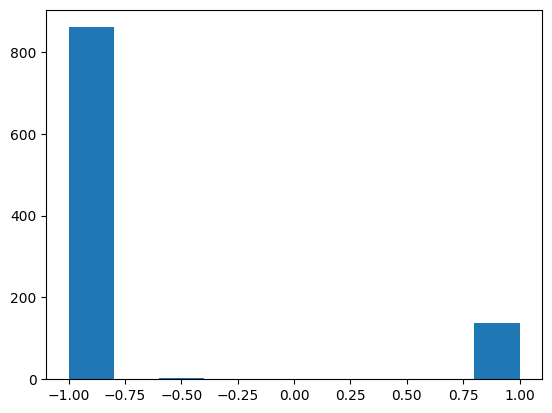

In [69]:
results = []
for i in range(1000):
    doc1 = document_index[random.randint(0, len(document_index)-1)]
    doc2 = document_index[random.randint(0, len(document_index)-1)]

    results.append(
        lcl_author_distance_metric(doc1, doc2)
    )

plt.hist(results)
plt.show


# Fix topic

In [76]:
doc_types = []
for doc in document_index:
    doc_types.append(
        [topic.strip() for topic in re.split(r"[>|,]", doc.metadata["Topics"])]
    )

doc_types = [item for sublist in doc_types for item in sublist]
set(doc_types)

{'Asia and EMEs',
 'Bank Funcding and Capital',
 'Bank Funding and Capital',
 'Business Conditions',
 'Chartpack',
 'Consumption and Household',
 'Credit Conditions',
 'Euro Area',
 'Financial Markets',
 'Fiscal Policy',
 'Forecast',
 'GDP',
 'Government Sector',
 'Housing',
 'Housing Market',
 'Includes Fim Data/Of Supervisory Interest',
 'Inflation',
 'Inflation Expectations',
 'Interest Rates',
 'International',
 'Investment and Corporate',
 'Labour Market',
 'MPC',
 'Methodology',
 'Monetary Strategy',
 'Money and Credit',
 'Near Term Outlook',
 'Policy',
 'Productivity',
 'Quantitative Easing',
 'Spare capacity',
 'Supply',
 'Trade Volumes',
 'UK Trade',
 'US',
 'Unemployment',
 'World Activity'}

<function matplotlib.pyplot.show(close=None, block=None)>

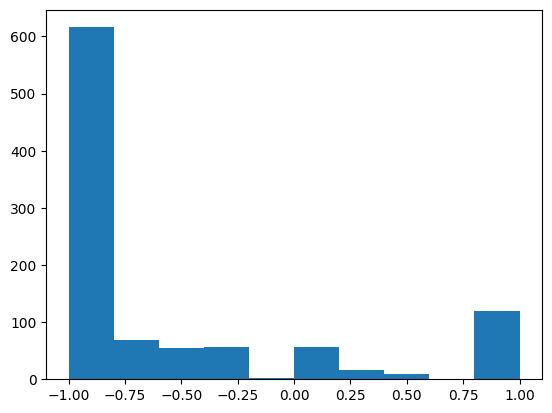

In [78]:
results = []
for i in range(1000):
    doc1 = document_index[random.randint(0, len(document_index)-1)]
    doc2 = document_index[random.randint(0, len(document_index)-1)]
    
    doc1_topics = re.split('r[>,]', doc1.metadata['Topics'])
    doc2_topics = re.split('r[>,]', doc2.metadata['Topics'])
    
    results.append(
        distance_metrics.topic_distance_metric(doc1, doc2)
        # distance_metrics.fuzzy_jaccard_similarity(doc1_topics, doc2_topics, threshold=80)
    )

plt.hist(results)
plt.show


In [79]:
doc1 = document_index[random.randint(0, 100)]
doc2 = document_index[random.randint(0, 100)]

doc1_topics = [topic.strip() for topic in re.split(r'[>|,]', doc1.metadata['Topics'])]
doc2_topics = [topic.strip() for topic in re.split(r'[>|,]', doc2.metadata['Topics'])]


print(doc1_topics, '||', doc2_topics, '||', distance_metrics.topic_distance_metric(doc1, doc2))

['Inflation', 'Inflation Expectations', 'Business Conditions'] || ['GDP', 'Inflation', 'Labour Market', 'MPC', 'International', 'Financial Markets'] || -0.428


# Brands

In [81]:
doc_types = []
for doc in document_index:
    doc_types.append(
        [topic.strip() for topic in re.split(r"[>|,]", doc.metadata["Brands"])]
    )

doc_types = [item for sublist in doc_types for item in sublist]
set(doc_types)

{'Agency',
 'Balance Sheet Model Note',
 'Bank Underground',
 'CAPD',
 'China Monitor',
 'Current Economic Conditions',
 'DSD',
 'External Forecasters',
 'Forecast',
 'Forecast Judgements Tracker',
 'Global Pulse',
 'International Analysis Note',
 'International Directorate',
 'International Forecast Note',
 'MA-wide',
 'MASD',
 'MFAD',
 'MFCD',
 'Monetary and Financial Conditions',
 'Note for Record',
 'Pre-MPC Follow Up Questions',
 'Quarterly Asset Price Note',
 'Research Insights',
 'Research Summary',
 'SEAD',
 'SED',
 'Structural Economics Division',
 'nan'}

In [119]:

doc1 = embedded_index[random.randint(0, len(embedded_index)-1)]
doc2 = embedded_index[random.randint(0, len(embedded_index)-1)]

doc1.metadata['Brands']

'MA-wide > Note for Record'

<function matplotlib.pyplot.show(close=None, block=None)>

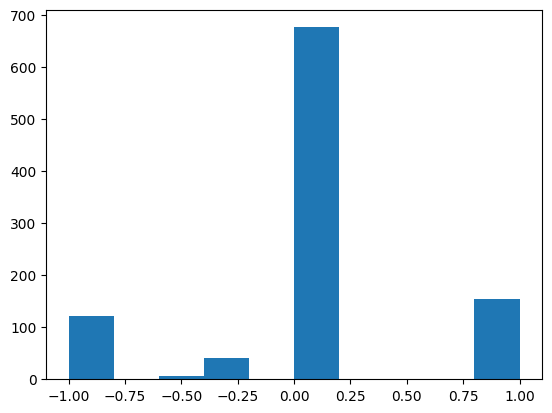

In [82]:
results = []
for i in range(1000):
    doc1 = document_index[random.randint(0, len(document_index)-1)]
    doc2 = document_index[random.randint(0, len(document_index)-1)]
    
    results.append(
        distance_metrics.brand_distance_metric(doc1, doc2)
        # distance_metrics.fuzzy_jaccard_similarity(doc1_topics, doc2_topics, threshold=80)
    )

plt.hist(results)
plt.show


In [123]:
set(results)

{-1.0, -0.334, 0, 1.0, 3.0}

In [125]:
doc1 = embedded_index[random.randint(0, 100)]
doc2 = embedded_index[random.randint(0, 100)]

doc1_brands = [brand.strip() for brand in re.split(r'[>|,]', doc1.metadata['Brands'])]
doc2_brands = [brand.strip() for brand in re.split(r'[>|,]', doc2.metadata['Brands'])]

print(doc1_brands, '||', doc2_brands, '||', distance_metrics.brand_distance_metric(doc1, doc2))

['nan'] || ['nan'] || 0


In [19]:
doc1_brands[0].lower() == 'nan'

True

# Division

In [100]:
doc_types = []
for doc in embedded_index:
    doc_types.append(doc.metadata['Divisions'])

set(doc_types)

# embedded_index[0].metadata

{'Agencies',
 'Centre for Central Bkg Studies, Research Hub',
 "Conj Ass'Ment & Projectn - Div 4",
 'Current Economic Conditions Division',
 'External Engagement Division',
 'FS, Statistics and Regulatory Data',
 'International Directorate',
 'MP COO Division',
 'Markets',
 'Markets, Monetary and Financial Conditions',
 'Monetary Analysis, International Directorate',
 'Monetary Analysis, Monetary Policy Outlook Division',
 'Monetary Policy Outlook Division',
 'Monetary Policy Outlook Division, International Directorate',
 'Monetary Policy Outlook Division, Monetary and Financial Conditions',
 'Monetary Policy Outlook Division, Prudential Policy Division',
 'Monetary and Financial Conditions',
 'Monetary and Financial Conditions, Macro-Financial Risk Division',
 'Monetary and Financial Conditions, Markets, International Directorate',
 'Research Hub',
 'Structural Economics Division'}

In [104]:
doc1 = embedded_index[random.randint(0, len(embedded_index)-1)]
doc2 = embedded_index[random.randint(0, len(embedded_index)-1)]

<function matplotlib.pyplot.show(close=None, block=None)>

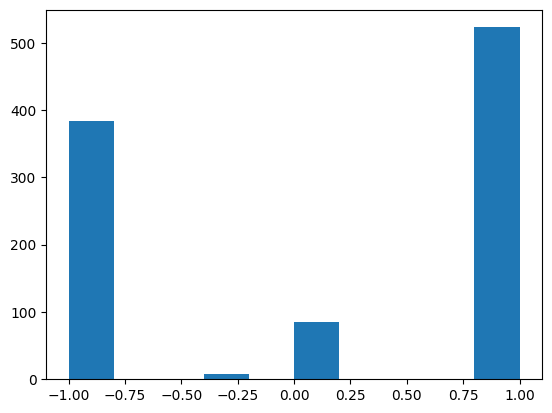

In [186]:
results = []
for i in range(1000):
    doc1 = embedded_index[random.randint(0, len(embedded_index)-1)]
    doc2 = embedded_index[random.randint(0, len(embedded_index)-1)]
    
    results.append(
        distance_metrics.division_distance_metric(doc1, doc2, fuzz_thresh=80)
    )

plt.hist(results)
plt.show

In [187]:
set(results)

{-1.0, -0.334, 0.0, 1.0}

In [153]:
doc1 = embedded_index[random.randint(0, 100)]
doc2 = embedded_index[random.randint(0, 100)]

doc1_divisions = [brand.strip() for brand in re.split(r'[>|,]', doc1.metadata['Divisions'])]
doc2_divisions = [brand.strip() for brand in re.split(r'[>|,]', doc2.metadata['Divisions'])]

# print(doc1_brands, '||', doc2_brands, '||', distance_metrics.fuzzy_jaccard_similarity(doc1_divisions, doc2_divisions,80))
print(doc1_divisions, '||', doc2_divisions, '||', distance_metrics.division_distance_metric(doc1, doc2,80))

['Markets']
0.0
['Markets'] || ['Research Hub'] || -1.0


In [132]:
print(doc1_brands, '||', doc2_brands, '||', distance_metrics.division_distance_metric(doc1, doc2,80))

0.0
['nan'] || ['nan'] || -1.0


# Other

In [188]:
embedded_index[0].metadata

{'page_label': '1',
 'file_name': 'Agencies Pay and Labour Market Survey (MPC Note - January 2020).pdf',
 'Description': 'For 2020, survey respondents expect pay settlements to remain flat at the 2.9% reported for 2019. \nIn contrast, respondents expect growth in total labour costs per employee to increase somewhat.  While the difference could partly reflect the impact of non-pay benefits and changes in the composition of the workforce, we would put more weight on the steer from the settlements responses for the outlook for pay growth. \nAs in 2019, the “Ability to recruit and retain staff” and “the National Living Wage” are driving up the growth rate of total labour costs per employee in 2020.  “Brexit Uncertainty”, “Changes in profitability” and “Economic Uncertainty” continue to pull down on the change in the growth rate of total labour costs per employee. ',
 'Type': 'Recommended reading',
 'Date': '2020-01-15 00:00:00',
 'Authors': 'Florence Hubert, Frances Hill, Louise Parreira, 